In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import sys


import itertools
import numpy as np
import pandas as pd
from scipy import sparse
from scipy import ndimage

import matplotlib.pyplot as plt

import networkx as nx


from src.depth import DepthPoset
from src import poset_scores

from tqdm import tqdm

# Load Image

/tmp/ipykernel_65605/766850352.py:3: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  image = ndimage.zoom(image, (0.5, 0.5, 1), order=1, grid_mode=True)


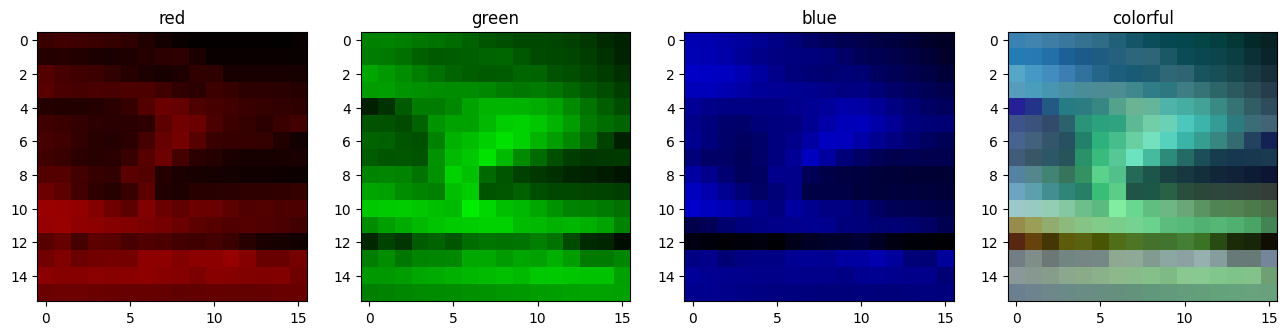

In [3]:
path = 'source/aurora.png'
image = plt.imread(path)[:, :, :3]
image = ndimage.zoom(image, (0.5, 0.5, 1), order=1, grid_mode=True)



fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for i, color in enumerate(['red', 'green', 'blue']):
    axs[i].set_title(color)
    image_to_show = np.zeros(image.shape)
    image_to_show[:, :, i] = image[:, :, i]
    axs[i].imshow(image_to_show)

#axs[3].set_title('black-white')
#axs[3].imshow(image.mean(axis=2).reshape([image.shape[0], image.shape[1], 1]) * np.ones([1, 1, 3]))

axs[3].set_title('colorful')
axs[3].imshow(image)

plt.show()

# Get border matrix from image

In [4]:
def get_unsorted_order(n, m, with_dims=True):
    """
    """
    # define order
    edges0 = [((x, y), (x+1, y)) for x, y in itertools.product(range(n - 1), range(m))]
    edges1 = [((x, y), (x, y+1)) for x, y in itertools.product(range(n), range(m - 1))]
    squares = list(itertools.product(range(n), range(m)))
    order = squares + edges0 + edges1

    if not with_dims:
        return order

    # define dimensions
    dims = np.concatenate([np.zeros(n*m, dtype=int), np.ones(2*n*m - n - m, dtype=int)])
    assert len(dims) == len(order)

    return order, dims

In [5]:
def get_order_filtrations(img):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    edges0_filtration = np.concatenate(np.max([img[1:, :], img[:-1, :]], axis=0))
    edges1_filtration = np.concatenate(np.max([img[:, 1:], img[:, :-1]], axis=0))
    squares_filtration = np.concatenate(img)

    filtration = np.concatenate([squares_filtration, edges0_filtration, edges1_filtration, ])
    return filtration

In [6]:
def get_sorted_order(img, with_dims=True, with_filtration=True):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    order, dims = get_unsorted_order(image.shape[0], image.shape[1])
    filtration = get_order_filtrations(img)

    indices = np.lexsort((dims, filtration))
    order = [order[i] for i in indices]
    dims = dims[indices]
    if with_filtration and with_dims:
        return order, dims, filtration
    if with_dims:
        return order, dims
    if with_filtration:
        return order, filtration
    return order

In [7]:
def diagonal_overlay(n, m):
    rows, cols, data = [], [], []

    for i in range(n):
        # Диагональ слева направо (↘)
        if i < m:
            rows.append(i)
            cols.append(i)
            data.append(True)

        # Диагональ справа налево (↘)
        if i < m:
            rows.append(n - i - 1)
            cols.append(m - i - 1)
            data.append(True)

    return sparse.csr_matrix((data, (rows, cols)), shape=(n, m), dtype=bool)


In [8]:

def transpose_minor_diagonal(bm: sparse.csr_matrix) ->sparse. csr_matrix:
    if bm.shape[0] != bm.shape[1]:
        raise ValueError("Matrix must be square to transpose along the minor diagonal.")
    
    n = bm.shape[0]
    bm_coo = bm.tocoo()
    
    # Меняем местами строки и столбцы, с отражением относительно последнего индекса
    new_row = n - 1 - bm_coo.col
    new_col = n - 1 - bm_coo.row
    
    # Создаём новую матрицу
    return sparse.coo_matrix((bm_coo.data, (new_row, new_col)), shape=(n, n)).tocsr()

In [9]:
def get_unsorted_border_matrix(n, m):
    """
    """
    # edges0
    matrix_e0 = diagonal_overlay(n*m - 1, n*m)
    mask = np.array([i % m != (m - 1) for i in range(matrix_e0.shape[0])])
    matrix_e0 = matrix_e0[mask]

    # edges1
    matrix_e1 = diagonal_overlay(m*(n-1), n*m)
    
    # dimension 1-2 submatrix
    bm = sparse.vstack([matrix_e0, matrix_e1])
    
    # geting full matrix
    N = 3*n*m - n - m
    bm = sparse.vstack([bm, sparse.csr_matrix((N - bm.shape[0], bm.shape[1]))])
    bm = sparse.hstack([sparse.csr_matrix((N, N - bm.shape[1])), bm])

    # transpose over minor diagonal
    bm = transpose_minor_diagonal(bm)
    
    return bm.astype(bool)

In [10]:
def get_sorted_border_matrix(img):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    n, m = img.shape
    bm = get_unsorted_border_matrix(n, m)

    order, dims = get_unsorted_order(image.shape[0], image.shape[1])
    filtration = get_order_filtrations(img)
    indices = np.lexsort((dims, filtration))

    bm = bm[indices, :]
    bm = bm[:, indices]
    
    return bm

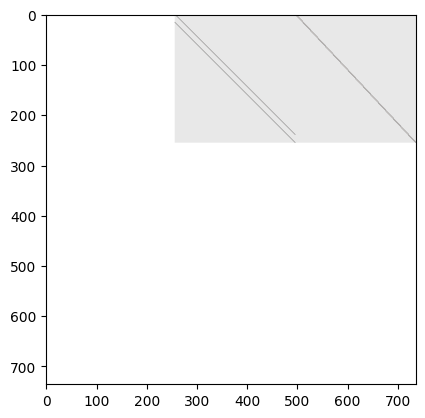

In [11]:
order, dims = get_unsorted_order(image.shape[0], image.shape[1])
bm = get_unsorted_border_matrix(image.shape[0], image.shape[1])

if len(dims) < 4096:
    matrix_dim_condition = dims.reshape((-1, 1)) == dims.reshape((1, -1)) - 1
    plt.imshow(matrix_dim_condition, cmap='Greys', vmin=0, vmax=6)

    bm_to_show = bm.toarray().astype(float)
    bm_to_show[bm_to_show == 0] = np.nan
    plt.imshow(bm_to_show, cmap='Reds')



# Experiment

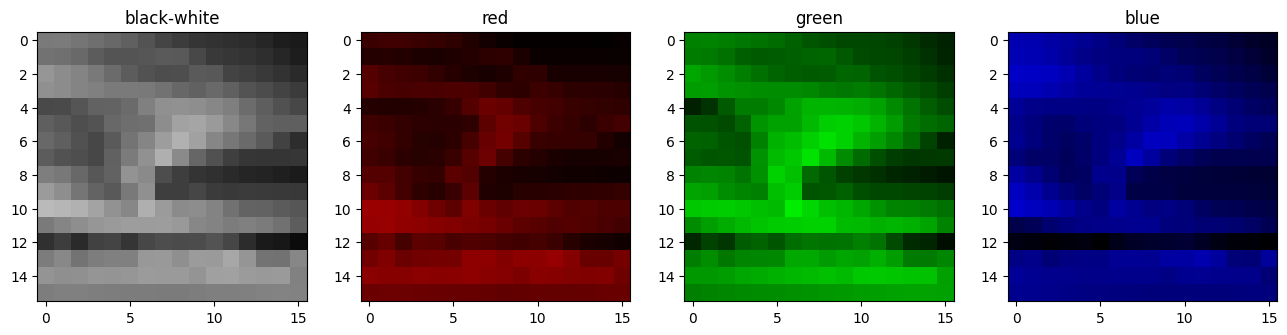

In [12]:
cases = {
    'black-white': image.mean(axis=2),
    'red': image[:, :, 0], 
    'green': image[:, :, 1], 
    'blue': image[:, :, 2], 
}

case_representations = {
    'black-white': lambda img: np.transpose([1*img, 1*img, 1*img], (1, 2, 0)), 
    'red': lambda img: np.transpose([1*img, 0*img, 0*img], (1, 2, 0)), 
    'green': lambda img: np.transpose([0*img, 1*img, 0*img], (1, 2, 0)), 
    'blue': lambda img: np.transpose([0*img, 0*img, 1*img], (1, 2, 0)), 
}

fig, axs = plt.subplots(1, len(cases), figsize=(4*len(cases), 4.5))

for i, key in enumerate(cases.keys()):
    axs[i].set_title(key)
    img = case_representations[key](cases[key])
    axs[i].imshow(img)




In [13]:
odfs = {key: get_sorted_order(img) for key, img in cases.items()}
bms = {key: get_sorted_border_matrix(img) for key, img in cases.items()}

dps = {key: DepthPoset.from_border_matrix(border_matrix=bms[key].toarray().astype('int8'), dims=odfs[key][1], filter_values=odfs[key][2], sources=odfs[key][0]) for key in tqdm(cases.keys(), total=len(cases))}

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


In [14]:
scores = [poset_scores.number_of_nodes, 
          poset_scores.number_of_relations, 
          poset_scores.number_of_components,
          poset_scores.height, 
          poset_scores.width,
          ]

case_scores = pd.DataFrame({key: {score.__name__: score(dp) for score in scores} for key, dp in dps.items()})
case_scores

,black-white,red,green,blue
number_of_nodes,255,255,255,255
number_of_relations,136,115,144,113
number_of_components,121,143,114,142
height,3,3,4,3
width,238,233,238,243


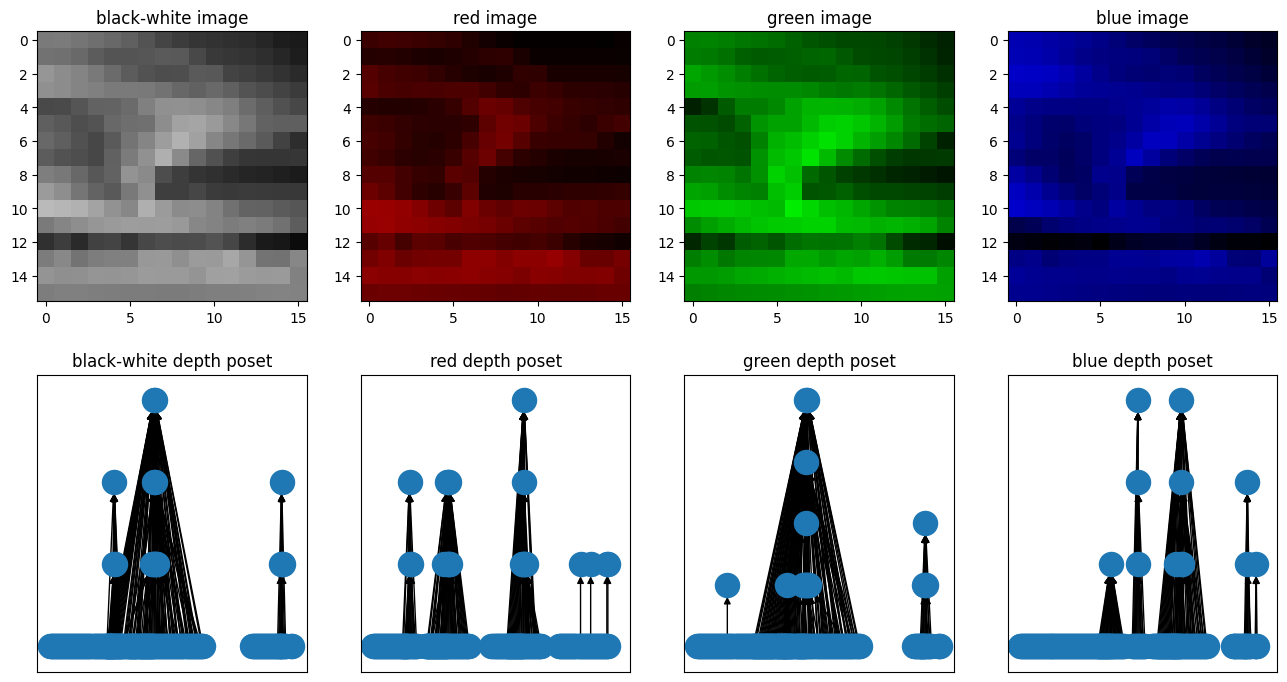

In [15]:

fig, axs = plt.subplots(2, len(cases), figsize=(4*len(cases), 8.5))

for i, key in enumerate(cases.keys()):
    axs[0, i].set_title(f'{key} image')
    img = case_representations[key](cases[key])
    axs[0, i].imshow(img)
    
    dp = dps[key]
    axs[1, i].set_title(f'{key} depth poset')
    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), ax=axs[1, i], with_labels=False)


In [16]:
def remove_minimal_nodes_from_depth_poset(dp: DepthPoset):
    # 
    nodes_to_remove = list(dp.iterate_minimal_nodes())
    return dp.subposet(lambda node: node not in nodes_to_remove)

In [17]:
df_dps = {key: [dp] for key, dp in dps.items()}

for i in range(max([poset_scores.height(dp) for dp in dps.values()]) + 1):
    for key, dp in dps.items():
        df_dps[key].append(remove_minimal_nodes_from_depth_poset(df_dps[key][-1]))

df_dps = pd.DataFrame(df_dps)
df_dps

,black-white,red,green,blue
0,<src.depth.DepthPoset object at 0x749269960050>,<src.depth.DepthPoset object at 0x74926bc300e0>,<src.depth.DepthPoset object at 0x74926bd2e9c0>,<src.depth.DepthPoset object at 0x74926bbe3350>
1,<src.depth.DepthPoset object at 0x74926be55a30>,<src.depth.DepthPoset object at 0x74926826c3e0>,<src.depth.DepthPoset object at 0x749268286ba0>,<src.depth.DepthPoset object at 0x74926bdfd6a0>
2,<src.depth.DepthPoset object at 0x74926bd2fbf0>,<src.depth.DepthPoset object at 0x7492681436b0>,<src.depth.DepthPoset object at 0x749268178b30>,<src.depth.DepthPoset object at 0x7492681435c0>
3,<src.depth.DepthPoset object at 0x7492681285f0>,<src.depth.DepthPoset object at 0x74926817bf50>,<src.depth.DepthPoset object at 0x74926817b1d0>,<src.depth.DepthPoset object at 0x749268179730>
4,<src.depth.DepthPoset object at 0x749268179010>,<src.depth.DepthPoset object at 0x749268162cc0>,<src.depth.DepthPoset object at 0x74926829bd70>,<src.depth.DepthPoset object at 0x749268162300>
5,<src.depth.DepthPoset object at 0x749268179520>,<src.depth.DepthPoset object at 0x749268179820>,<src.depth.DepthPoset object at 0x74926817b3b0>,<src.depth.DepthPoset object at 0x74926817be90>


In [18]:
def get_node_difference(dp0, dp1):
    return set(dp0.nodes) - set(dp1.nodes)

In [19]:
df_edges = pd.DataFrame({key: df_dps[key].apply(lambda dp: [node.source[1] for node in get_node_difference(dps[key], dp)]) for key in cases.keys()})
df_edges

,black-white,red,green,blue
0,[],[],[],[]
1,"[((2, 6), (3, 6)), ((0, 6), (1, 6)), ((12, 15)...","[((4, 2), (4, 3)), ((1, 0), (1, 1)), ((2, 6), ...","[((2, 6), (3, 6)), ((12, 15), (13, 15)), ((0, ...","[((2, 6), (3, 6)), ((3, 4), (4, 4)), ((0, 6), ..."
2,"[((6, 2), (7, 2)), ((2, 6), (3, 6)), ((0, 6), ...","[((4, 2), (4, 3)), ((1, 0), (1, 1)), ((2, 6), ...","[((2, 6), (3, 6)), ((12, 15), (13, 15)), ((0, ...","[((2, 6), (3, 6)), ((3, 4), (4, 4)), ((0, 6), ..."
3,"[((6, 2), (7, 2)), ((4, 1), (4, 2)), ((2, 6), ...","[((4, 2), (4, 3)), ((1, 0), (1, 1)), ((2, 6), ...","[((2, 6), (3, 6)), ((12, 15), (13, 15)), ((0, ...","[((2, 6), (3, 6)), ((3, 4), (4, 4)), ((0, 6), ..."
4,"[((6, 2), (7, 2)), ((4, 1), (4, 2)), ((2, 6), ...","[((4, 2), (4, 3)), ((1, 0), (1, 1)), ((2, 6), ...","[((2, 6), (3, 6)), ((12, 15), (13, 15)), ((0, ...","[((2, 6), (3, 6)), ((3, 4), (4, 4)), ((0, 6), ..."
5,"[((6, 2), (7, 2)), ((4, 1), (4, 2)), ((2, 6), ...","[((4, 2), (4, 3)), ((1, 0), (1, 1)), ((2, 6), ...","[((2, 6), (3, 6)), ((12, 15), (13, 15)), ((0, ...","[((2, 6), (3, 6)), ((3, 4), (4, 4)), ((0, 6), ..."


In [20]:
def get_components(edges, nodes=None):
    # 
    g = nx.Graph()
    if nodes is not None:
        g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    components = [list(component) for component in nx.connected_components(g)]
    return components

In [21]:
pixels = list(itertools.product(range(image.shape[0]), range(image.shape[1])))

In [22]:
df_components = df_edges.applymap(lambda e: get_components(e, pixels))
df_components.applymap(len)

/tmp/ipykernel_65605/1475150133.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_components = df_edges.applymap(lambda e: get_components(e, pixels))
/tmp/ipykernel_65605/1475150133.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_components.applymap(len)


,black-white,red,green,blue
0,256,256,256,256
1,18,23,18,13
2,7,7,6,6
3,3,2,4,3
4,1,1,3,1
5,1,1,1,1


In [23]:
def get_simplified_image(img, components):
    #
    new_img = img*np.nan
    for comp in components:
        x, y = np.transpose(comp)
        new_img[x, y] = img[x, y].mean()
    return new_img

In [24]:
df_simplified_imgs = pd.DataFrame({key: df_components[key].apply(lambda comp: get_simplified_image(cases[key], comp)) for key in cases.keys()})

df_simplified_imgs

,black-white,red,green,blue
0,"[[0.4787582, 0.48562095, 0.46209154, 0.4369281...","[[0.22843137, 0.2509804, 0.24411765, 0.2294117...","[[0.50980395, 0.51862746, 0.49509805, 0.469607...","[[0.69803923, 0.6872549, 0.64705884, 0.6117647..."
1,"[[0.4460318, 0.4460318, 0.4460318, 0.4460318, ...","[[0.25330883, 0.25330883, 0.20900737, 0.209007...","[[0.49518332, 0.49518332, 0.49518332, 0.495183...","[[0.4763841, 0.4763841, 0.4763841, 0.4763841, ..."
2,"[[0.36872143, 0.36872143, 0.36872143, 0.368721...","[[0.18458334, 0.18458334, 0.18458334, 0.184583...","[[0.53808445, 0.53808445, 0.53808445, 0.538084...","[[0.48759428, 0.48759428, 0.48759428, 0.487594..."
3,"[[0.36872143, 0.36872143, 0.36872143, 0.368721...","[[0.27499518, 0.27499518, 0.27499518, 0.274995...","[[0.45812818, 0.45812818, 0.45812818, 0.458128...","[[0.48759428, 0.48759428, 0.48759428, 0.487594..."
4,"[[0.4126545, 0.4126545, 0.4126545, 0.4126545, ...","[[0.2783088, 0.2783088, 0.2783088, 0.2783088, ...","[[0.45720378, 0.45720378, 0.45720378, 0.457203...","[[0.45865887, 0.45865887, 0.45865887, 0.458658..."
5,"[[0.4126545, 0.4126545, 0.4126545, 0.4126545, ...","[[0.2783088, 0.2783088, 0.2783088, 0.2783088, ...","[[0.50099576, 0.50099576, 0.50099576, 0.500995...","[[0.45865887, 0.45865887, 0.45865887, 0.458658..."


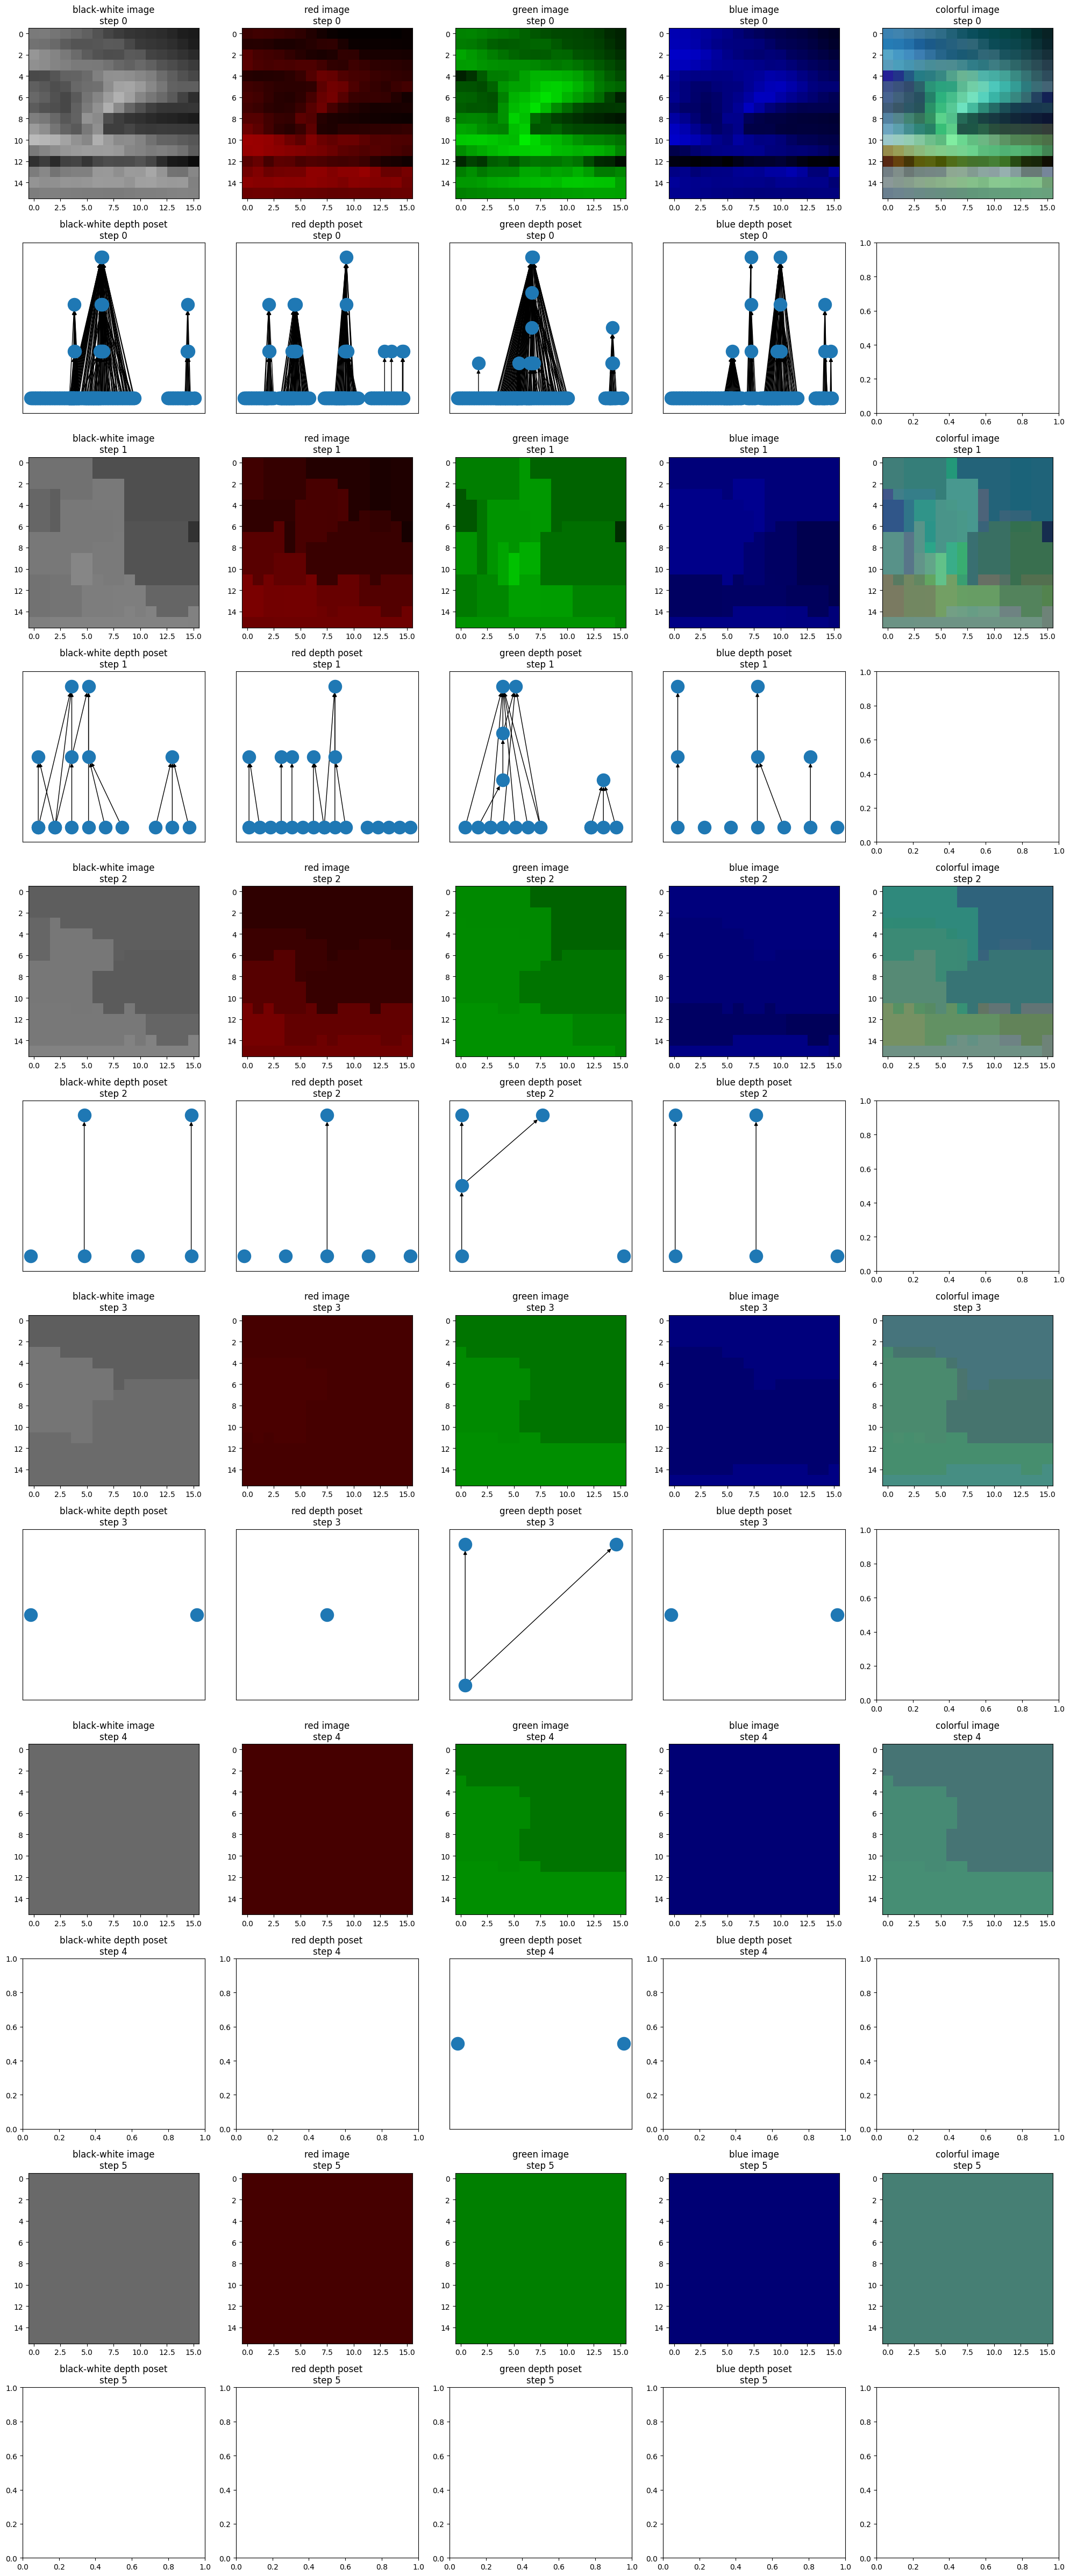

In [28]:
rows = 2*len(df_simplified_imgs)
cols = len(cases) + 1

fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
#fig.suptitle(f'Simplifying the image with Depth Poset')

for i in range(len(df_simplified_imgs)):
    for j, key in enumerate(cases.keys()):
        axs[2*i, j].set_title(f'{key} image\nstep {i}')
        img = case_representations[key](df_simplified_imgs.loc[i, key])
        axs[2*i, j].imshow(img)

        axs[2*i + 1, j].set_title(f'{key} depth poset\nstep {i}')
        dp = df_dps.loc[i, key]
        nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), ax=axs[2*i + 1, j], with_labels=False)
    
for i in range(len(df_simplified_imgs)):
    axs[2*i, -1].set_title(f'colorful image\nstep {i}')
    img = [df_simplified_imgs.loc[i, key] for key in ['red', 'green', 'blue']]
    img = np.transpose(img, [1, 2, 0])
    axs[2*i, -1].imshow(img)

plt.tight_layout()
plt.savefig('pics/simplifying_with_depth_poset.png')

# Reduction algorithms for sparse border matrices